## Lies `cars.csv` in einen DataFrame

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import randint, norm
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR

df = pd.read_csv('./data/cars.csv')
df

,price,yearOfRegistration,powerPS,kilometer,model,fuelType,name
0,1450,1997,75,90000,andere,benzin,Toyota_Toyota_Starlet_1._Hand__TÜV_neu
1,13100,2005,280,5000,golf,benzin,R32_tauschen_oder_kaufen
2,4500,2008,87,90000,yaris,benzin,Toyota_Yaris_1.3_VVT_i
3,6000,2009,177,125000,3er,diesel,320_Alpinweiss_Kohlenstoff
4,3990,1999,118,90000,3er,benzin,BMW_318i_E46_+++_1._Hand_+++_Liebhaberfahrzeug
...,...,...,...,...,...,...,...
245,23400,2014,160,40000,kaefer,benzin,Volkswagen_1.4_TSI_DSG_R_Line
246,9000,2014,67,20000,i_reihe,benzin,Hyundai_i10_1.0_Fifa_World_Cup_Edition
247,5500,2009,109,125000,ceed,benzin,Kia_Ceed_1.4_/_TÜV_Neu
248,1600,2002,75,125000,clio,benzin,Renault_Clio_1.2_16V


## Data Cleaning

* entferne die Features `model` und `name`
* entferne Observations mit `NaN`-Einträgen
* entferne Observations, deren `fuelType` nicht `benzin` oder `diesel` ist
* Führe ein One-Hot-Encoding für `fuelType` durch

In [2]:
df = df.drop(columns=['model','name'])
df = df.dropna()
df.isna().sum()


price                 0
yearOfRegistration    0
powerPS               0
kilometer             0
fuelType              0
dtype: int64

In [3]:
df = df[df['fuelType'] != 'lpg']
df

,price,yearOfRegistration,powerPS,kilometer,fuelType
0,1450,1997,75,90000,benzin
1,13100,2005,280,5000,benzin
2,4500,2008,87,90000,benzin
3,6000,2009,177,125000,diesel
4,3990,1999,118,90000,benzin
...,...,...,...,...,...
245,23400,2014,160,40000,benzin
246,9000,2014,67,20000,benzin
247,5500,2009,109,125000,benzin
248,1600,2002,75,125000,benzin


In [4]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

transformer = ColumnTransformer(transformers=[
    ('one_hot', OneHotEncoder(), ['fuelType']),
], remainder='passthrough')

transformed = transformer.fit_transform(df)
df = pd.DataFrame(transformed, columns=transformer.get_feature_names_out())
df

,one_hot__fuelType_benzin,one_hot__fuelType_diesel,one_hot__fuelType_hybrid,remainder__price,remainder__yearOfRegistration,remainder__powerPS,remainder__kilometer
0,1.0,0.0,0.0,1450.0,1997.0,75.0,90000.0
1,1.0,0.0,0.0,13100.0,2005.0,280.0,5000.0
2,1.0,0.0,0.0,4500.0,2008.0,87.0,90000.0
3,0.0,1.0,0.0,6000.0,2009.0,177.0,125000.0
4,1.0,0.0,0.0,3990.0,1999.0,118.0,90000.0
...,...,...,...,...,...,...,...
233,1.0,0.0,0.0,23400.0,2014.0,160.0,40000.0
234,1.0,0.0,0.0,9000.0,2014.0,67.0,20000.0
235,1.0,0.0,0.0,5500.0,2009.0,109.0,125000.0
236,1.0,0.0,0.0,1600.0,2002.0,75.0,125000.0


## Training

* Verwende 20% Testdaten und `random_state=42`
* predicte `price`
* Verwende eine LinearRegression und ermittle, welches Feature einen negativen Einfluss auf den Preis hat
* Verwende einen RandomForestRegressor und ermittle das wichtigste Feature

In [5]:
X = df.drop(columns='remainder__price')
y = df.remainder__price
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
error = mean_squared_error(y_true=y_test, y_pred=predictions)
np.sqrt(error)

3790.5389359995934

In [46]:
model.coef_

array([-2133.81689571,  2838.55329261,  -704.7363969 ,  1182.6457285 ,
        6105.75566778, -6019.37154603])

<AxesSubplot:>

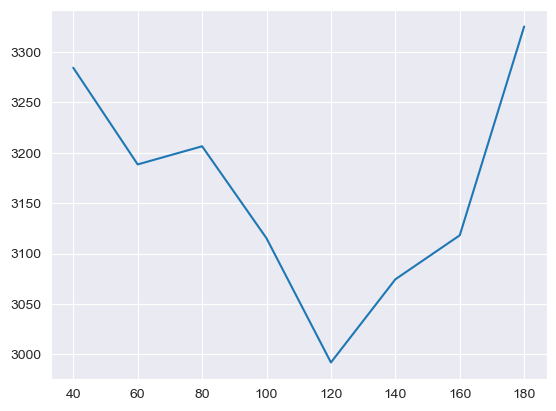

In [7]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
predictions = forest.predict(X_test)
error = mean_squared_error(y_true=y_test, y_pred=predictions)
np.sqrt(error)


errors = {}


def calc_error(model, X_test, y_true):
    predictions = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_true, predictions))


for n in range(40, 200, 20):
    forest = RandomForestRegressor(n_estimators=n)
    forest.fit(X_train, y_train)
    errors[n] = calc_error(forest, X_test, y_test)
sns.lineplot(data=errors, x=errors.keys(), y=errors.values())

In [61]:
forest.feature_importances_

##yearOfRegistration is the most important feature and price is the second most important feature

array([1.20521231e-02, 1.85574584e-02, 1.01217081e-04, 3.05520507e-01,
       4.43536243e-01, 2.20232452e-01])

## Evaluierung

* Ermittle den mean squared error für beide Modelle
* Performt eines der models besser, wenn die Daten skaliert werden?

In [48]:
predictions = model.predict(X_test)
error = mean_squared_error(y_true=y_test, y_pred=predictions)
np.sqrt(error)

3790.5389359995934

In [63]:
predictions = forest.predict(X_test)
error = mean_squared_error(y_true=y_test, y_pred=predictions)
np.sqrt(error)
## das RandomForrestRegression Model schneidet besser ab

3325.441167660295

### Tuning

Finde ein model, welches am Testset einen mse < 3200 aufweist

In [65]:
params = {'n_estimators': range(50, 90, 50),
          'max_features': [1.0, 'sqrt', 'log2']}
grid = GridSearchCV(estimator=RandomForestRegressor(),
                    param_grid=params,
                    scoring='neg_mean_squared_error',  # -mse, damit höher=besser
                    cv=5,
                    n_jobs=4)
grid.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=4,
             param_grid={'max_features': [1.0, 'sqrt', 'log2'],
                         'n_estimators': range(50, 90, 50)},
             scoring='neg_mean_squared_error')

In [66]:
predictions = grid.predict(X_test)
error = mean_squared_error(y_true=y_test, y_pred=predictions)
np.sqrt(error)
## mit etwas testen und analysieren der GridSearchCV cv_results_ konnte ich den Fehler auf 2941.752006125992 hinunter bringen

2941.752006125992

In [42]:
pd.DataFrame(grid.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.134792,0.011902,0.006784,0.003342,1.0,50,"{'max_features': 1.0, 'n_estimators': 50}",-5.331104e+07,-2.050817e+07,-4.032237e+07,-1.855763e+07,-1.746443e+07,-3.003273e+07,1.433955e+07,3
1,0.145209,0.044339,0.029332,0.042687,sqrt,50,"{'max_features': 'sqrt', 'n_estimators': 50}",-4.349884e+07,-2.095634e+07,-4.165163e+07,-1.402615e+07,-1.061793e+07,-2.615018e+07,1.383105e+07,2
2,0.156689,0.016627,0.020011,0.026571,log2,50,"{'max_features': 'log2', 'n_estimators': 50}",-4.402100e+07,-1.857175e+07,-3.861246e+07,-1.460065e+07,-1.322271e+07,-2.580571e+07,1.289981e+07,1
